In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import run_best_fit, log_model
from density_pericenter_fit_utils import run_best_fit_for_sim
from density_pericenter_fit_utils import run_best_fit_for_sim_with_mcmc
from satellite_properties_plot_utils import plot_median_relation


plt.style.use("pltstyle.mplstyle")
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (4.5, 7),
    "figure.subplot.left": 0.1,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.05,
    "figure.subplot.hspace": 0.05,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)

In [2]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

Vmax = Kaplinghat_data[:,2]
le_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,3]
he_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,4]
NFW_Vmax = 10**Vmax[::2] # Only NFW fit data; [km/s] units
le_NFW_Vmax = NFW_Vmax - 10**le_Vmax[::2] # Only NFW fit data; [km/s] units
he_NFW_Vmax = 10**he_Vmax[::2] - NFW_Vmax # Only NFW fit data; [km/s] units

Rmax = Kaplinghat_data[:,5]
le_Rmax = Kaplinghat_data[:,6] + Kaplinghat_data[:,5]
he_Rmax = Kaplinghat_data[:,7] + Kaplinghat_data[:,5]
NFW_Rmax = 10**Rmax[::2] # Only NFW fit data; [kpc] units
le_NFW_Rmax = NFW_Rmax - 10**le_Rmax[::2]  # Only NFW fit data; [kpc] units
he_NFW_Rmax = 10**he_Rmax[::2] - NFW_Rmax  # Only NFW fit data; [kpc] units
he_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2
le_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2

num_satellites = len(NFW_Rmax)
M200_K19 = np.zeros((3,num_satellites))
R200_K19 = np.zeros((3,num_satellites))

rho_s = np.zeros(num_satellites)
r_s = np.zeros(num_satellites)
r_range = np.arange(-4, 4, 0.01) # Some radial range
r_range = 10**r_range # to kpc

for i in range(num_satellites):
    rho_s[i] = calculate_rho_s(NFW_Vmax[i], NFW_Rmax[i])
    r_s[i] = calculate_r_s(NFW_Rmax[i])
    rho = NFW_profile(r_range, rho_s[i], r_s[i])
    mass_within_r = mass(rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[0, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[0, i] = calculate_M200(R200_K19[0, i])

    ## Dealing with error propagration..
    low_error_rho = rho - calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], le_NFW_Vmax[i], le_NFW_Rmax[i])
    mass_within_r = mass(low_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[1, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[1, i] = M200_K19[0, i] - calculate_M200(R200_K19[1, i])

    high_error_rho = rho + calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], he_NFW_Vmax[i], he_NFW_Rmax[i])
    mass_within_r = mass(high_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[2, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[2, i] = calculate_M200(R200_K19[2, i]) - M200_K19[0, i]

In [3]:
# We remove CVnI
num_satellites -= 1
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

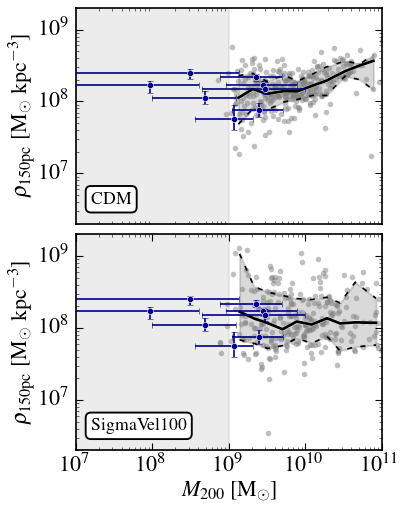

In [6]:
plt.figure()

DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = plt.subplot(2, 1, i+1)
    axs.fill_between(np.array([1e7, 1e9]), np.array([2e6, 2e6]), np.array([2e9, 2e9]), color='grey', alpha=0.15)

    # Add simulations points
    rp, rho150, M200 = [], [], []
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:10]:
                data_subhalo = file[f'{subhalo_idx}']

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                rho = NFW_profile(r_range, rho_s, r_s)
                mass_within_r = mass(rho, r_range)
                rho_within_r = rho_mean(mass_within_r, r_range)
                R200 = calculate_R200(rho_within_r, r_range)
                _M200 = calculate_M200(R200)
                M200 = np.append(M200, _M200)

    axs.plot(M200, rho150, 'o', ms=5, color='grey', markeredgecolor='none', alpha=0.5)
    m_bins = np.arange(9, 11.2, 0.2)
    m_bins = 10**m_bins
    select = np.where(M200>=1e9)[0]
    plot_median_relation(axs, m_bins, M200[select], rho150[select], color='black')

    axs.errorbar(M200_K19[0,:-1], rho_150pc_K19[0,:], yerr=rho_150pc_K19[1:,:], xerr=M200_K19[1:,:-1],
                 marker='o', markersize=5.5, markeredgecolor="white", ls='none', lw=1.5, c='darkblue',label='K19', zorder=1000)
    
    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=16, verticalalignment='top', bbox=props, zorder=1000)
        
    plt.axis([1e7, 1e11, 2e6, 2e9])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    
    if i == 0:
        plt.xticks([])
    else:
        plt.xlabel(r"$M_{200}$ [M$_{\odot}$]")

    ####
    file.close()

plt.savefig('Density_M200.png',dpi=300)
plt.show()